In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-19 13:28:46.293638: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 13:28:46.318735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:28:46.759650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def data_imdb():
    dataset = load_dataset("imdb")
    train_data = dataset['train']
    test_data = dataset['test']

    df_train = train_data.to_pandas()  # Convert the training dataset to a Pandas DataFrame
    df_test = test_data.to_pandas()  # Convert the validation dataset to a Pandas DataFrame

    df_train['sentiment'] = df_train['label'].map({0: 'bad', 1: 'good'})
    df_test['sentiment'] = df_test['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df_train.sentiment.unique()  # Get unique category labels from the training DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df_train['label'] = df_train.sentiment.replace(label_dict)
    df_test['label'] = df_test.sentiment.replace(label_dict)

    df_train['data_type'] = 'train'  # Set the 'data_type' column to 'train' for training data
    df_test['data_type'] = 'test'  # Set the 'data_type' column to 'val' for validation data

    df = pd.concat([df_train, df_test], ignore_index=True)  # Merge the training and validation dataframes

    return df


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_imdb_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = data_imdb()

Found cached dataset imdb (/home/z123010/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,text,label,sentiment,data_type
33553,Forget what I said about Emeril. Rachael Ray i...,0,bad,test
9427,Former private eye-turned-security guard ditch...,0,bad,train
199,Mann photographs the Alberta Rocky Mountains i...,0,bad,train
12447,Simply put: the movie is boring. Cliché upon c...,0,bad,train
39489,"Now being a fan of sci fi, the trailer for thi...",1,good,test
42724,"In 'Hoot' Logan Lerman plays Roy Eberhardt, th...",1,good,test
10822,This is the worst film I have ever seen.I was ...,0,bad,train
49498,I think that Toy Soldiers is an excellent movi...,1,good,test
4144,I think Micheal Ironsides acting career must b...,0,bad,train
36958,This was a disgrace to the game FarCry i had m...,0,bad,test


In [6]:
df.groupby(['sentiment']).count()

,text,label,data_type
sentiment,,,
bad,25000,25000,25000
good,25000,25000,25000


In [7]:
df.groupby(['data_type']).count()

,text,label,sentiment
data_type,,,
test,25000,25000,25000
train,25000,25000,25000


In [8]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_test_text = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_test = encoded_data_test_text['input_ids']
attention_masks_test = encoded_data_test_text['attention_mask']

labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [9]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
len(dataset_train), len(dataset_test)

(25000, 25000)

In [10]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config(
            vocab_size=50257,
            hidden_size=256,  # Increase hidden size
            num_hidden_layers=8,  # Increase number of layers
            num_attention_heads=8,  # Increase number of attention heads
            intermediate_size=1024,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.gpt = GPT2Model(config=gpt_config)
        self.gpt_ln = nn.LayerNorm(gpt_config.hidden_size)
        
        bert_config = BertConfig(
            vocab_size=50257,
            hidden_size=256,  # Increase hidden size
            num_hidden_layers=8,  # Increase number of layers
            num_attention_heads=8,  # Increase number of attention heads
            intermediate_size=1024,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.bert = BertModel(config=bert_config)
        self.bert_ln = nn.LayerNorm(bert_config.hidden_size)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        gpt_outputs = self.gpt_ln(gpt_outputs) + gpt_outputs  # Residual connection
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert_ln(bert_outputs) + bert_outputs  # Residual connection
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs


In [11]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(1024, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (gpt_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50257, 256, padding_idx=0)
      (posi

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 16 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-7,
    eps=1e-8,
    weight_decay=0.01

)


epochs = 50
patience = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [18]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=dataset_train,
eval_dataset=dataset_train,
)

In [19]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

    # Append the metrics for this fold to the overall lists
    training_loss_lists.append(fold_training_loss_list)
    validation_loss_lists.append(fold_validation_loss_list)
    accuracy_lists.append(fold_accuracy_list)
    precision_lists.append(fold_precision_list)
    f1_score_lists.append(fold_f1_score_list)


Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

model.load_state_dict(
    torch.load(
        "Models/finetuned_gpt_bert_imdb_ft_epoch24.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals, label_dict)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.782964779475774
Validation loss: 0.651499754007398
F1 Score (weighted): 0.6189749436881808


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7006722647371069
Validation loss: 0.6060718250289913
F1 Score (weighted): 0.6667792643998811
10.51% Training loss decreased compared to the previous epoch
6.97% Validation loss decreased compared to the previous epoch
7.72% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6392946096922204
Validation loss: 0.5573314098273038
F1 Score (weighted): 0.7156725382403872
8.76% Training loss decreased compared to the previous epoch
8.04% Validation loss decreased compared to the previous epoch
7.33% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5846698181736782
Validation loss: 0.5442088356555004
F1 Score (weighted): 0.7301697955731492
8.54% Training loss decreased compared to the previous epoch
2.35% Validation loss decreased compared to the previous epoch
2.03% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5381363491979828
Validation loss: 0.5864412348696
F1 Score (weighted): 0.6992156520534273
7.96% Training loss decreased compared to the previous epoch
7.76% Validation loss increased compared to the previous epoch
4.24% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.5090182397432503
Validation loss: 0.4680354074311043
F1 Score (weighted): 0.7776148201491427
5.41% Training loss decreased compared to the previous epoch
20.19% Validation loss decreased compared to the previous epoch
11.21% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.48354172035681076
Validation loss: 0.4719412821516042
F1 Score (weighted): 0.7813786704781964
5.01% Training loss decreased compared to the previous epoch
0.83% Validation loss increased compared to the previous epoch
0.48% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.46091854562764484
Validation loss: 0.442907333388324
F1 Score (weighted): 0.7928787053161452
4.68% Training loss decreased compared to the previous epoch
6.15% Validation loss decreased compared to the previous epoch
1.47% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.4409427314456592
Validation loss: 0.4324565023298227
F1 Score (weighted): 0.8000082493096604
4.33% Training loss decreased compared to the previous epoch
2.36% Validation loss decreased compared to the previous epoch
0.9% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.42150742464778945
Validation loss: 0.43913122770863317
F1 Score (weighted): 0.8004658277519818
4.41% Training loss decreased compared to the previous epoch
1.54% Validation loss increased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.4015412513635306
Validation loss: 0.41304573386440424
F1 Score (weighted): 0.8133995912704647
4.74% Training loss decreased compared to the previous epoch
5.94% Validation loss decreased compared to the previous epoch
1.62% F1 Score increased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.3904149946230434
Validation loss: 0.4112921615255733
F1 Score (weighted): 0.818351501466007
2.77% Training loss decreased compared to the previous epoch
0.42% Validation loss decreased compared to the previous epoch
0.61% F1 Score increased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.37818061789152213
Validation loss: 0.4048541978106465
F1 Score (weighted): 0.8189421168086678
3.13% Training loss decreased compared to the previous epoch
1.57% Validation loss decreased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 14:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.3673821712659398
Validation loss: 0.48561146805540767
F1 Score (weighted): 0.786609990280085
2.86% Training loss decreased compared to the previous epoch
19.95% Validation loss increased compared to the previous epoch
3.95% F1 Score decreased compared to the previous epoch


Epoch 15:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.35415413085829306
Validation loss: 0.40965552314858517
F1 Score (weighted): 0.8235238752273518
3.6% Training loss decreased compared to the previous epoch
15.64% Validation loss decreased compared to the previous epoch
4.69% F1 Score increased compared to the previous epoch


Epoch 16:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.3462603135509701
Validation loss: 0.39976723933317154
F1 Score (weighted): 0.8289153219891101
2.23% Training loss decreased compared to the previous epoch
2.41% Validation loss decreased compared to the previous epoch
0.65% F1 Score increased compared to the previous epoch


Epoch 17:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.3407427942792024
Validation loss: 0.3971020080702128
F1 Score (weighted): 0.8292483657186928
1.59% Training loss decreased compared to the previous epoch
0.67% Validation loss decreased compared to the previous epoch
0.04% F1 Score increased compared to the previous epoch


Epoch 18:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.33238119036276964
Validation loss: 0.3846642963960052
F1 Score (weighted): 0.8331168960750132
2.45% Training loss decreased compared to the previous epoch
3.13% Validation loss decreased compared to the previous epoch
0.47% F1 Score increased compared to the previous epoch


Epoch 19:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.3193972391588051
Validation loss: 0.39541542817023956
F1 Score (weighted): 0.8335980170131597
3.91% Training loss decreased compared to the previous epoch
2.79% Validation loss increased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 20:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.312567058638236
Validation loss: 0.3849673215478602
F1 Score (weighted): 0.8365977496683799
2.14% Training loss decreased compared to the previous epoch
2.64% Validation loss decreased compared to the previous epoch
0.36% F1 Score increased compared to the previous epoch


Epoch 21:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.304571732402102
Validation loss: 0.3844860639918884
F1 Score (weighted): 0.8393984093605247
2.56% Training loss decreased compared to the previous epoch
0.13% Validation loss decreased compared to the previous epoch
0.33% F1 Score increased compared to the previous epoch


Epoch 22:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.2968750688768314
Validation loss: 0.44201964417964656
F1 Score (weighted): 0.8225372347667461
2.53% Training loss decreased compared to the previous epoch
14.96% Validation loss increased compared to the previous epoch
2.01% F1 Score decreased compared to the previous epoch


Epoch 23:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.2985411252847634
Validation loss: 0.38632659805236685
F1 Score (weighted): 0.84079999898112
0.56% Training loss increased compared to the previous epoch
12.6% Validation loss decreased compared to the previous epoch
2.22% F1 Score increased compared to the previous epoch


Epoch 24:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.288366599576369
Validation loss: 0.3778285907434868
F1 Score (weighted): 0.8431183935323497
3.41% Training loss decreased compared to the previous epoch
2.2% Validation loss decreased compared to the previous epoch
0.28% F1 Score increased compared to the previous epoch


Epoch 25:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.28582870392969467
Validation loss: 0.41931330694466046
F1 Score (weighted): 0.8354956542431764
0.88% Training loss decreased compared to the previous epoch
10.98% Validation loss increased compared to the previous epoch
0.9% F1 Score decreased compared to the previous epoch


Epoch 26:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.284107506542593
Validation loss: 0.39759215524316466
F1 Score (weighted): 0.8439124751066813
0.6% Training loss decreased compared to the previous epoch
5.18% Validation loss decreased compared to the previous epoch
1.01% F1 Score increased compared to the previous epoch


Epoch 27:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.281220548802771
Validation loss: 0.4469285018525193
F1 Score (weighted): 0.8199839633713859
1.02% Training loss decreased compared to the previous epoch
12.41% Validation loss increased compared to the previous epoch
2.84% F1 Score decreased compared to the previous epoch


Epoch 28:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.2756783615522399
Validation loss: 0.38789480167392804
F1 Score (weighted): 0.8417578302343903
1.97% Training loss decreased compared to the previous epoch
13.21% Validation loss decreased compared to the previous epoch
2.66% F1 Score increased compared to the previous epoch


Epoch 29:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.2691458402573533
Validation loss: 0.3903198748843665
F1 Score (weighted): 0.8420434835969586
2.37% Training loss decreased compared to the previous epoch
0.63% Validation loss increased compared to the previous epoch
0.03% F1 Score increased compared to the previous epoch


Epoch 30:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.25967695359564263
Validation loss: 0.38537568756470353
F1 Score (weighted): 0.8454096289059982
3.52% Training loss decreased compared to the previous epoch
1.27% Validation loss decreased compared to the previous epoch
0.4% F1 Score increased compared to the previous epoch


Epoch 31:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.2616901418568822
Validation loss: 0.3967990945626625
F1 Score (weighted): 0.8469085563986932
0.78% Training loss increased compared to the previous epoch
2.96% Validation loss increased compared to the previous epoch
0.18% F1 Score increased compared to the previous epoch


Epoch 32:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.2573293373961724
Validation loss: 0.4011732647630433
F1 Score (weighted): 0.8462534831069314
1.67% Training loss decreased compared to the previous epoch
1.1% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 33:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.2567507979938629
Validation loss: 0.40387583510522385
F1 Score (weighted): 0.8502742445419603
0.22% Training loss decreased compared to the previous epoch
0.67% Validation loss increased compared to the previous epoch
0.48% F1 Score increased compared to the previous epoch


Epoch 34:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.2562329659467482
Validation loss: 0.3943674088004674
F1 Score (weighted): 0.8436784408609991
0.2% Training loss decreased compared to the previous epoch
2.35% Validation loss decreased compared to the previous epoch
0.78% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 307.0270910104116 minutes
Final Accuracy: 0.84396
Final Precision: 0.8464560824808088


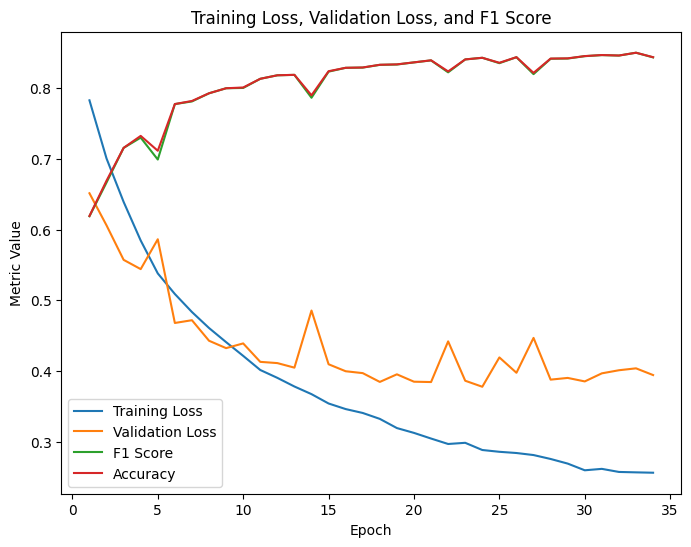

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy               Precision
--------------------  -------------------  -------------------  ------------------  ------------------  ------------
1                     0.782964779475774    0.651499754007398    0.6189749436881808  0.6194                  0.619935
2                     0.7006722647371069   0.6060718250289913   0.6667792643998811  0.6667792643998811      0.666779
3                     0.6392946096922204   0.5573314098273038   0.7156725382403872  0.7156725382403872      0.715673
4                     0.5846698181736782   0.5442088356555004   0.7301697955731492  0.7301697955731492      0.73017
5                     0.5381363491979828   0.5864412348696      0.6992156520534273  0.6992156520534273      0.699216
6                     0.5090182397432503   0.4680354074311043   0.7776148201491427  0.7776148201491427      0.777615
7                     0.48354172035681076  0.4719412821516042   0

([0.782964779475774,
  0.7006722647371069,
  0.6392946096922204,
  0.5846698181736782,
  0.5381363491979828,
  0.5090182397432503,
  0.48354172035681076,
  0.46091854562764484,
  0.4409427314456592,
  0.42150742464778945,
  0.4015412513635306,
  0.3904149946230434,
  0.37818061789152213,
  0.3673821712659398,
  0.35415413085829306,
  0.3462603135509701,
  0.3407427942792024,
  0.33238119036276964,
  0.3193972391588051,
  0.312567058638236,
  0.304571732402102,
  0.2968750688768314,
  0.2985411252847634,
  0.288366599576369,
  0.28582870392969467,
  0.284107506542593,
  0.281220548802771,
  0.2756783615522399,
  0.2691458402573533,
  0.25967695359564263,
  0.2616901418568822,
  0.2573293373961724,
  0.2567507979938629,
  0.2562329659467482],
 [0.651499754007398,
  0.6060718250289913,
  0.5573314098273038,
  0.5442088356555004,
  0.5864412348696,
  0.4680354074311043,
  0.4719412821516042,
  0.442907333388324,
  0.4324565023298227,
  0.43913122770863317,
  0.41304573386440424,
  0.411292

In [20]:
train_model(trainer, dataloader_train, dataloader_test, epochs, patience)


Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2503452508623613
Validation loss: 0.3915664114096576
F1 Score (weighted): 0.8631817889975193


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.24576104578496552
Validation loss: 0.3598043958353958
F1 Score (weighted): 0.8706908436199959
1.83% Training loss decreased compared to the previous epoch
8.11% Validation loss decreased compared to the previous epoch
0.87% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.24586986635653427
Validation loss: 0.3414165277959435
F1 Score (weighted): 0.8743419898646484
0.04% Training loss increased compared to the previous epoch
5.11% Validation loss decreased compared to the previous epoch
0.42% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.24343741980501118
Validation loss: 0.34018593482008785
F1 Score (weighted): 0.8723128570647063
0.99% Training loss decreased compared to the previous epoch
0.36% Validation loss decreased compared to the previous epoch
0.23% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.239596554084119
Validation loss: 0.35541636954732003
F1 Score (weighted): 0.8738562797249949
1.58% Training loss decreased compared to the previous epoch
4.48% Validation loss increased compared to the previous epoch
0.18% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.23739212197228451
Validation loss: 0.3491260433201767
F1 Score (weighted): 0.8772018692592103
0.92% Training loss decreased compared to the previous epoch
1.77% Validation loss decreased compared to the previous epoch
0.38% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.23307801468010567
Validation loss: 0.3572319380013616
F1 Score (weighted): 0.876007311020877
1.82% Training loss decreased compared to the previous epoch
2.32% Validation loss increased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.23501072394216133
Validation loss: 0.34968520189000735
F1 Score (weighted): 0.8771461013024873
0.83% Training loss increased compared to the previous epoch
2.11% Validation loss decreased compared to the previous epoch
0.13% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.2296320156047985
Validation loss: 0.35254514205512727
F1 Score (weighted): 0.8743109348478287
2.29% Training loss decreased compared to the previous epoch
0.82% Validation loss increased compared to the previous epoch
0.32% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.2309339242142062
Validation loss: 0.3536035335996443
F1 Score (weighted): 0.874707900396593
0.57% Training loss increased compared to the previous epoch
0.3% Validation loss increased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.22943014824298272
Validation loss: 0.35799381614419495
F1 Score (weighted): 0.8730708618567318
0.65% Training loss decreased compared to the previous epoch
1.24% Validation loss increased compared to the previous epoch
0.19% F1 Score decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.228024876875738
Validation loss: 0.3553299074695938
F1 Score (weighted): 0.8718163758672108
0.61% Training loss decreased compared to the previous epoch
0.74% Validation loss decreased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.22457674066301148
Validation loss: 0.3561480222091933
F1 Score (weighted): 0.8722700471050393
1.51% Training loss decreased compared to the previous epoch
0.23% Validation loss increased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 14:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.22357730212036914
Validation loss: 0.3440965118159534
F1 Score (weighted): 0.8755667943797686
0.45% Training loss decreased compared to the previous epoch
3.38% Validation loss decreased compared to the previous epoch
0.38% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 126.38237909078597 minutes
Final Accuracy: 0.8756
Final Precision: 0.8755967546362569


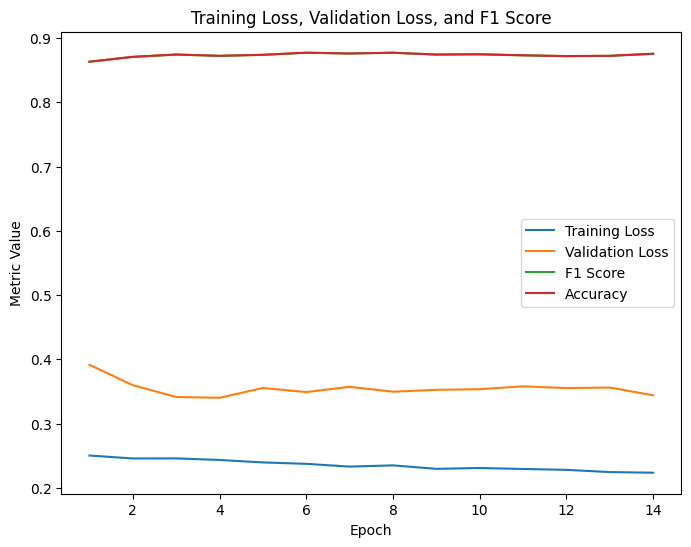

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.2503452508623613   0.3915664114096576   0.8631817889975193  0.8632                 0.866157
2                     0.24576104578496552  0.3598043958353958   0.8706908436199959  0.8706908436199959     0.870691
3                     0.24586986635653427  0.3414165277959435   0.8743419898646484  0.8743419898646484     0.874342
4                     0.24343741980501118  0.34018593482008785  0.8723128570647063  0.8723128570647063     0.872313
5                     0.239596554084119    0.35541636954732003  0.8738562797249949  0.8738562797249949     0.873856
6                     0.23739212197228451  0.3491260433201767   0.8772018692592103  0.8772018692592103     0.877202
7                     0.23307801468010567  0.3572319380013616   0.876007

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.23832191416613796
Validation loss: 0.17055282489972035
F1 Score (weighted): 0.9380101707355211


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2373722805929527
Validation loss: 0.16570876289016692
F1 Score (weighted): 0.9355484298566822
0.4% Training loss decreased compared to the previous epoch
2.84% Validation loss decreased compared to the previous epoch
0.26% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.23666825377155298
Validation loss: 0.16504103968892792
F1 Score (weighted): 0.9355740908018152
0.3% Training loss decreased compared to the previous epoch
0.4% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.23400813208922067
Validation loss: 0.1645435244438185
F1 Score (weighted): 0.9376012787900679
1.12% Training loss decreased compared to the previous epoch
0.3% Validation loss decreased compared to the previous epoch
0.22% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2335709874354721
Validation loss: 0.16811272343264738
F1 Score (weighted): 0.9355894072144681
0.19% Training loss decreased compared to the previous epoch
2.17% Validation loss increased compared to the previous epoch
0.21% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.23320788749465196
Validation loss: 0.16425020701495135
F1 Score (weighted): 0.9375956833315826
0.16% Training loss decreased compared to the previous epoch
2.3% Validation loss decreased compared to the previous epoch
0.21% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.23083457401235455
Validation loss: 0.1653527785122252
F1 Score (weighted): 0.936389538801866
1.02% Training loss decreased compared to the previous epoch
0.67% Validation loss increased compared to the previous epoch
0.13% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.23555702384456717
Validation loss: 0.16435528794973853
F1 Score (weighted): 0.9363913727438398
2.05% Training loss increased compared to the previous epoch
0.6% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.236299053877698
Validation loss: 0.1673620307853647
F1 Score (weighted): 0.9363913727438398
0.32% Training loss increased compared to the previous epoch
1.83% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.23134267463943872
Validation loss: 0.1646756603209017
F1 Score (weighted): 0.9363913727438398
2.1% Training loss decreased compared to the previous epoch
1.61% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.2316446692812539
Validation loss: 0.16826071820939612
F1 Score (weighted): 0.9363913727438398
0.13% Training loss increased compared to the previous epoch
2.18% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.23215996416936965
Validation loss: 0.16436364633108305
F1 Score (weighted): 0.9363913727438398
0.22% Training loss increased compared to the previous epoch
2.32% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.231608266115133
Validation loss: 0.16463363746916698
F1 Score (weighted): 0.9363913727438398
0.24% Training loss decreased compared to the previous epoch
0.16% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.23039174543570545
Validation loss: 0.16489144348076717
F1 Score (weighted): 0.9363913727438398
0.53% Training loss decreased compared to the previous epoch
0.16% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.23316775009171095
Validation loss: 0.16463588304509214
F1 Score (weighted): 0.9363913727438398
1.2% Training loss increased compared to the previous epoch
0.15% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.23192382772607356
Validation loss: 0.1644296695709608
F1 Score (weighted): 0.9363913727438398
0.53% Training loss decreased compared to the previous epoch
0.13% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 144.51393991311392 minutes
Final Accuracy: 0.9364
Final Precision: 0.9364190428588638


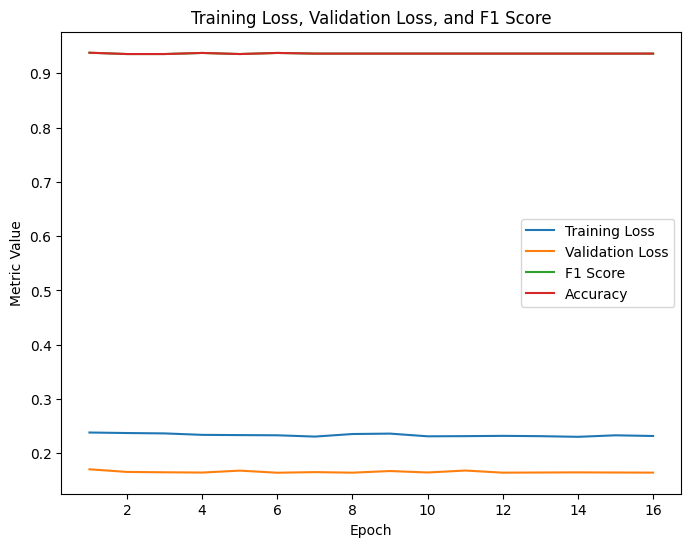

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.23832191416613796  0.17055282489972035  0.9380101707355211  0.938                  0.938208
2                     0.2373722805929527   0.16570876289016692  0.9355484298566822  0.9355484298566822     0.935548
3                     0.23666825377155298  0.16504103968892792  0.9355740908018152  0.9355740908018152     0.935574
4                     0.23400813208922067  0.1645435244438185   0.9376012787900679  0.9376012787900679     0.937601
5                     0.2335709874354721   0.16811272343264738  0.9355894072144681  0.9355894072144681     0.935589
6                     0.23320788749465196  0.16425020701495135  0.9375956833315826  0.9375956833315826     0.937596
7                     0.23083457401235455  0.1653527785122252   0.936389

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.23170149961305092
Validation loss: 0.17110233416389317
F1 Score (weighted): 0.9408


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.23248161691722183
Validation loss: 0.17136630102114123
F1 Score (weighted): 0.9408
0.34% Training loss increased compared to the previous epoch
0.15% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.23122637766177084
Validation loss: 0.17125608913517396
F1 Score (weighted): 0.9408
0.54% Training loss decreased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.22936985292488493
Validation loss: 0.17647055094575237
F1 Score (weighted): 0.9408
0.8% Training loss decreased compared to the previous epoch
3.04% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.23188497118920606
Validation loss: 0.1711642673820447
F1 Score (weighted): 0.9408
1.1% Training loss increased compared to the previous epoch
3.01% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.22988701722099478
Validation loss: 0.17142382227062325
F1 Score (weighted): 0.9408
0.86% Training loss decreased compared to the previous epoch
0.15% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.22840654993841494
Validation loss: 0.17105626176663075
F1 Score (weighted): 0.9408
0.64% Training loss decreased compared to the previous epoch
0.21% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.22835093038785453
Validation loss: 0.17107940377121802
F1 Score (weighted): 0.9408
0.02% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.23252742563247913
Validation loss: 0.17112806937093758
F1 Score (weighted): 0.9408
1.83% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.23340839429115764
Validation loss: 0.17120044599554152
F1 Score (weighted): 0.9408
0.38% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.23041829791591206
Validation loss: 0.1716825965002986
F1 Score (weighted): 0.9408
1.28% Training loss decreased compared to the previous epoch
0.28% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.23058683135332944
Validation loss: 0.1711526508116798
F1 Score (weighted): 0.9408
0.07% Training loss increased compared to the previous epoch
0.31% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.23042139724425192
Validation loss: 0.17270717154713763
F1 Score (weighted): 0.9408
0.07% Training loss decreased compared to the previous epoch
0.91% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.23232173218670504
Validation loss: 0.17170561861341735
F1 Score (weighted): 0.9408
0.82% Training loss increased compared to the previous epoch
0.58% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.23183574521710254
Validation loss: 0.17141806141467422
F1 Score (weighted): 0.9408
0.21% Training loss decreased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.23323059289543424
Validation loss: 0.17451907240542447
F1 Score (weighted): 0.9408
0.6% Training loss increased compared to the previous epoch
1.81% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.23273966992015777
Validation loss: 0.17109255827251513
F1 Score (weighted): 0.9408
0.21% Training loss decreased compared to the previous epoch
1.96% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 153.6011746962865 minutes
Final Accuracy: 0.9408
Final Precision: 0.9410035358704397


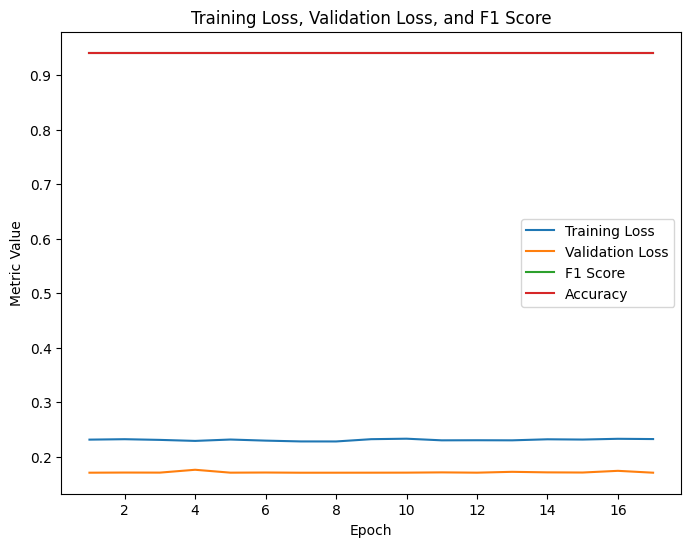

Epoch                 Training Loss        Validation Loss      F1 Score    Accuracy      Precision
--------------------  -------------------  -------------------  ----------  ----------  -----------
1                     0.23170149961305092  0.17110233416389317  0.9408      0.9408         0.941004
2                     0.23248161691722183  0.17136630102114123  0.9408      0.9408         0.9408
3                     0.23122637766177084  0.17125608913517396  0.9408      0.9408         0.9408
4                     0.22936985292488493  0.17647055094575237  0.9408      0.9408         0.9408
5                     0.23188497118920606  0.1711642673820447   0.9408      0.9408         0.9408
6                     0.22988701722099478  0.17142382227062325  0.9408      0.9408         0.9408
7                     0.22840654993841494  0.17105626176663075  0.9408      0.9408         0.9408
8                     0.22835093038785453  0.17107940377121802  0.9408      0.9408         0.9408
9             

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2330212018398969
Validation loss: 0.17794168104898114
F1 Score (weighted): 0.9367969231084601


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.23073660837970913
Validation loss: 0.1763734671044027
F1 Score (weighted): 0.9367969231084601
0.98% Training loss decreased compared to the previous epoch
0.88% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.23117108949375365
Validation loss: 0.17713152545142422
F1 Score (weighted): 0.9367969231084601
0.19% Training loss increased compared to the previous epoch
0.43% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.23362944240919456
Validation loss: 0.1763834792877411
F1 Score (weighted): 0.9367969231084601
1.06% Training loss increased compared to the previous epoch
0.42% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.23247629176598908
Validation loss: 0.1764317372766365
F1 Score (weighted): 0.9367969231084601
0.49% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.22745091518434857
Validation loss: 0.17707390042769303
F1 Score (weighted): 0.9367969231084601
2.16% Training loss decreased compared to the previous epoch
0.36% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.23083969708611526
Validation loss: 0.17642052916833645
F1 Score (weighted): 0.9367969231084601
1.49% Training loss increased compared to the previous epoch
0.37% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.2331811035887286
Validation loss: 0.1766868951125367
F1 Score (weighted): 0.9367969231084601
1.01% Training loss increased compared to the previous epoch
0.15% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.22958370424309307
Validation loss: 0.17661525399845307
F1 Score (weighted): 0.9367969231084601
1.54% Training loss decreased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.23110060664039442
Validation loss: 0.18032712613345142
F1 Score (weighted): 0.9367969231084601
0.66% Training loss increased compared to the previous epoch
2.1% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.2293054981914421
Validation loss: 0.1763753036250639
F1 Score (weighted): 0.9367969231084601
0.78% Training loss decreased compared to the previous epoch
2.19% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.2309695551169913
Validation loss: 0.17683567193924052
F1 Score (weighted): 0.9367969231084601
0.73% Training loss increased compared to the previous epoch
0.26% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 108.4577218413353 minutes
Final Accuracy: 0.9368
Final Precision: 0.9367986469344609


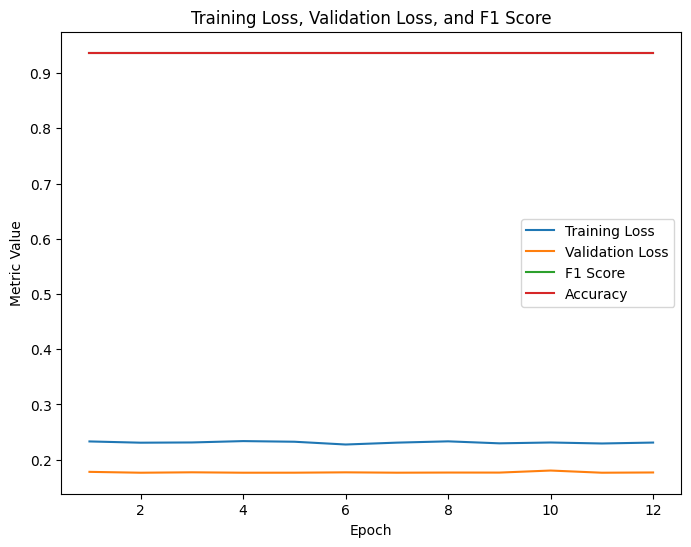

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.2330212018398969   0.17794168104898114  0.9367969231084601  0.9368                 0.936799
2                     0.23073660837970913  0.1763734671044027   0.9367969231084601  0.9367969231084601     0.936797
3                     0.23117108949375365  0.17713152545142422  0.9367969231084601  0.9367969231084601     0.936797
4                     0.23362944240919456  0.1763834792877411   0.9367969231084601  0.9367969231084601     0.936797
5                     0.23247629176598908  0.1764317372766365   0.9367969231084601  0.9367969231084601     0.936797
6                     0.22745091518434857  0.17707390042769303  0.9367969231084601  0.9367969231084601     0.936797
7                     0.23083969708611526  0.17642052916833645  0.936796

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2325309780237676
Validation loss: 0.16649450944250177
F1 Score (weighted): 0.9396036243624363


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.23201637447023316
Validation loss: 0.1664657111599994
F1 Score (weighted): 0.9396036243624363
0.22% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.23118709211615684
Validation loss: 0.16696785985059134
F1 Score (weighted): 0.9396036243624363
0.36% Training loss decreased compared to the previous epoch
0.3% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2297374223985768
Validation loss: 0.17015880084994017
F1 Score (weighted): 0.9396036243624363
0.63% Training loss decreased compared to the previous epoch
1.91% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.23050996786554018
Validation loss: 0.1679564256897303
F1 Score (weighted): 0.9396036243624363
0.34% Training loss increased compared to the previous epoch
1.29% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2307568551918231
Validation loss: 0.16800436831026036
F1 Score (weighted): 0.9396036243624363
0.11% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2339480069115779
Validation loss: 0.16714683934678412
F1 Score (weighted): 0.9396036243624363
1.38% Training loss increased compared to the previous epoch
0.51% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.23033152069557555
Validation loss: 0.1667570425316122
F1 Score (weighted): 0.9396036243624363
1.55% Training loss decreased compared to the previous epoch
0.23% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.2323375629921733
Validation loss: 0.1686199051654263
F1 Score (weighted): 0.9396036243624363
0.87% Training loss increased compared to the previous epoch
1.12% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.2330117262218097
Validation loss: 0.16784614225505454
F1 Score (weighted): 0.9396036243624363
0.29% Training loss increased compared to the previous epoch
0.46% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.23513815384795037
Validation loss: 0.16642198611234735
F1 Score (weighted): 0.9396036243624363
0.91% Training loss increased compared to the previous epoch
0.85% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.23112611136483274
Validation loss: 0.1668890712539529
F1 Score (weighted): 0.9396036243624363
1.71% Training loss decreased compared to the previous epoch
0.28% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.2295578604788462
Validation loss: 0.1668597404180676
F1 Score (weighted): 0.9396036243624363
0.68% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.23398663979434087
Validation loss: 0.16699123580103656
F1 Score (weighted): 0.9396036243624363
1.93% Training loss increased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.23451936785290553
Validation loss: 0.16647277787553183
F1 Score (weighted): 0.9396036243624363
0.23% Training loss increased compared to the previous epoch
0.31% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

    # Append the metrics for this fold to the overall lists
    training_loss_lists.append(fold_training_loss_list)
    validation_loss_lists.append(fold_validation_loss_list)
    accuracy_lists.append(fold_accuracy_list)
    precision_lists.append(fold_precision_list)
    f1_score_lists.append(fold_f1_score_list)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.23160957066671872
Validation loss: 0.3965749220781967
F1 Score (weighted): 0.8543353826796728


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.23155505533410234
Validation loss: 0.39646163596983186
F1 Score (weighted): 0.8543353826796728
0.02% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.23164321157112241
Validation loss: 0.39642804195676584
F1 Score (weighted): 0.8543353826796728
0.04% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.23870952393563083
Validation loss: 0.3964286116252743
F1 Score (weighted): 0.8543353826796728
3.05% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2273205524408434
Validation loss: 0.3965599890953253
F1 Score (weighted): 0.8543353826796728
4.77% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2320662111437111
Validation loss: 0.3965029522433391
F1 Score (weighted): 0.8543353826796728
2.09% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2299237803389883
Validation loss: 0.39646774126003453
F1 Score (weighted): 0.8543353826796728
0.92% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.234096762003389
Validation loss: 0.3964633584604673
F1 Score (weighted): 0.8543353826796728
1.81% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.23420737973363392
Validation loss: 0.3964418156920996
F1 Score (weighted): 0.8543353826796728
0.05% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.22921093599903897
Validation loss: 0.39648325538402157
F1 Score (weighted): 0.8543353826796728
2.13% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.23323693339181395
Validation loss: 0.39643842584715105
F1 Score (weighted): 0.8543353826796728
1.76% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.228861353280686
Validation loss: 0.3965685520299084
F1 Score (weighted): 0.8543353826796728
1.88% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.23217921708422556
Validation loss: 0.39644109374728537
F1 Score (weighted): 0.8543353826796728
1.45% Training loss increased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 117.31511528889338 minutes
Final Accuracy: 0.85436
Final Precision: 0.8545997094035568


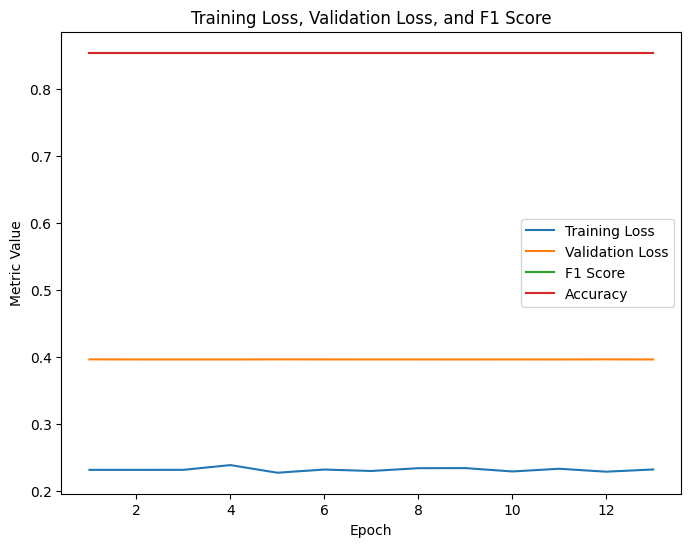

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.23160957066671872  0.3965749220781967   0.8543353826796728  0.85436                0.8546
2                     0.23155505533410234  0.39646163596983186  0.8543353826796728  0.8543353826796728     0.854335
3                     0.23164321157112241  0.39642804195676584  0.8543353826796728  0.8543353826796728     0.854335
4                     0.23870952393563083  0.3964286116252743   0.8543353826796728  0.8543353826796728     0.854335
5                     0.2273205524408434   0.3965599890953253   0.8543353826796728  0.8543353826796728     0.854335
6                     0.2320662111437111   0.3965029522433391   0.8543353826796728  0.8543353826796728     0.854335
7                     0.2299237803389883   0.39646774126003453  0.85433538

([0.23160957066671872,
  0.23155505533410234,
  0.23164321157112241,
  0.23870952393563083,
  0.2273205524408434,
  0.2320662111437111,
  0.2299237803389883,
  0.234096762003389,
  0.23420737973363392,
  0.22921093599903897,
  0.23323693339181395,
  0.228861353280686,
  0.23217921708422556],
 [0.3965749220781967,
  0.39646163596983186,
  0.39642804195676584,
  0.3964286116252743,
  0.3965599890953253,
  0.3965029522433391,
  0.39646774126003453,
  0.3964633584604673,
  0.3964418156920996,
  0.39648325538402157,
  0.39643842584715105,
  0.3965685520299084,
  0.39644109374728537],
 [0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436,
  0.85436],
 [0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.8545997094035568,
  0.85

In [22]:
train_model(trainer, dataloader_train, dataloader_test, epochs, patience)